In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz, corner

In [2]:
from jkepler.kepler import *
from jkepler.rv import rv_unit_amplitude as getrv

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
#sns.set_palette('colorblind')
from matplotlib import rc
rc('text', usetex=False)

## simulated data

In [4]:
t0, period, K, ecc, omega, gamma = 0, 10., 100., 0.4, 0.3 * np.pi, 20.
sigma = 20.
N = 100

In [5]:
np.random.seed(123)
t = (np.random.rand(N) - 0.5 ) * 20

In [6]:
def rvmodel(t, t0, period, K, ecc, omega, gamma):
    tau =t0_to_tau(t0, period, ecc, omega)
    return K * getrv(t, period, ecc, omega, tau) + gamma

In [7]:
np.random.seed(123)
y_true = rvmodel(t, t0, period, K, ecc, omega, gamma)
y_obs = y_true + np.random.randn(N) * sigma
error_obs = np.ones(N) * sigma

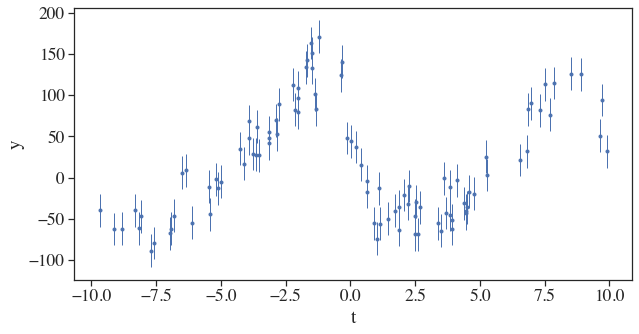

In [8]:
plt.figure(figsize=(10,5))
plt.xlabel("t")
plt.ylabel("y")
plt.errorbar(t, y_obs, fmt='.', yerr=error_obs, lw=1);

## 1. sampling using cosw and sinw
- $e \sim \mathcal{U}(0, e_{\rm max})$
- $\cos\omega \sim \mathcal{N}(0,1), \sin\omega \sim \mathcal{N}(0,1)$

In [9]:
def model(t, y, yerr, t0_guess, period_guess, emax=0.95):
    logK = numpyro.sample("logK", dist.Uniform(-5, 5))
    K = numpyro.deterministic("K", 10**logK)

    ecc = numpyro.sample("ecc", dist.Uniform(0, emax))
    cosw = numpyro.sample("cosw", dist.Normal())
    sinw = numpyro.sample("sinw", dist.Normal())
    omega = numpyro.deterministic("omega", jnp.arctan2(sinw, cosw))

    period = numpyro.sample("period", dist.Uniform(period_guess*0.95, period_guess*1.05))
    t0 = numpyro.sample("t0", dist.Uniform(t0_guess-0.1*period_guess, t0_guess+0.1*period_guess))
    tau = numpyro.deterministic("tau", t0_to_tau(t0, period, ecc, omega))
    
    rv_no_offset = numpyro.deterministic("rv_no_offset", K * getrv(t, period, ecc, omega, tau))
    gamma = numpyro.sample("gamma", dist.Uniform(low=-30, high=30))
    rvmodel = numpyro.deterministic("rvmodel", rv_no_offset + gamma)
    
    numpyro.sample("obs", dist.Normal(rvmodel, yerr), obs=y)

In [10]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.95)

In [11]:
n_wm = 1000
n_sample = 1000

In [12]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_wm, num_samples=n_sample)

In [13]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t, y_obs, error_obs, 0, 10.)

sample: 100%|███████████████████████████████████| 2000/2000 [00:09<00:00, 212.73it/s, 127 steps of size 4.49e-02. acc. prob=0.94]


In [14]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosw      0.69      0.39      0.63      0.07      1.23    257.18      1.00
       ecc      0.38      0.04      0.38      0.32      0.44    384.64      1.00
     gamma     20.55      2.00     20.56     17.65     24.14    538.44      1.00
      logK      1.99      0.02      1.99      1.96      2.02    384.26      1.00
    period      9.98      0.08      9.97      9.86     10.11    412.95      1.00
      sinw      0.97      0.55      0.90      0.12      1.72    260.54      1.00
        t0      0.02      0.06      0.02     -0.07      0.12    422.01      1.00

Number of divergences: 1


In [15]:
samples = mcmc.get_samples()

In [16]:
params = ["K", "t0", "period", "ecc", "omega", "gamma"]

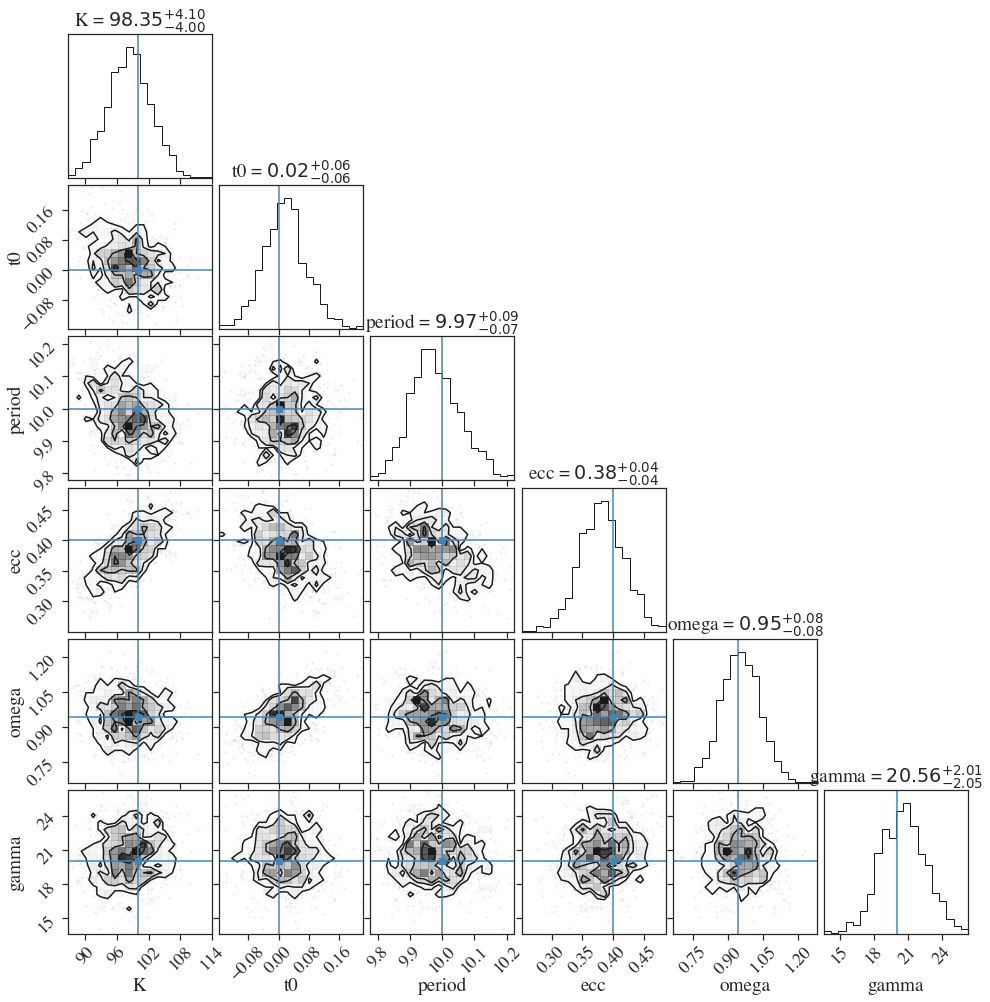

In [17]:
fig = corner.corner(np.array([np.array(samples[key]) for key in params]).T,
                   show_titles=True, truths=[K, t0, period, ecc, omega, gamma], labels=params)

## 2. sampling using sqrt(e)cosw and sqrt(e)sinw
- $\sqrt{e}\cos\omega \sim \mathcal{U}(-1,1), \sqrt{e}\sin\omega \sim \mathcal{U}(-1,1)$
- add $-\infty$ to log likelihood if $e > e_{\rm max}$

In [18]:
def model2(t, y, yerr, t0_guess, period_guess, emax=0.95):
    logK = numpyro.sample("logK", dist.Uniform(-5, 5))
    K = numpyro.deterministic("K", 10**logK)

    # using ecosw and esinw instead
    ecosw = numpyro.sample("ecosw", dist.Uniform(-1, 1))
    esinw = numpyro.sample("esinw", dist.Uniform(-1, 1))
    #ecc = numpyro.deterministic("ecc", jnp.sqrt(ecosw**2+esinw**2))
    ecc = numpyro.deterministic("ecc", ecosw**2+esinw**2)
    omega = numpyro.deterministic("omega", jnp.arctan2(esinw, ecosw))
    numpyro.factor("elimit", jnp.where(ecc > emax, -jnp.inf, 0))
    
    period = numpyro.sample("period", dist.Uniform(period_guess*0.95, period_guess*1.05))
    t0 = numpyro.sample("t0", dist.Uniform(t0_guess-0.1*period_guess, t0_guess+0.1*period_guess))
    tau = numpyro.deterministic("tau", t0_to_tau(t0, period, ecc, omega))
    
    rv_no_offset = numpyro.deterministic("rv_no_offset", K * getrv(t, period, ecc, omega, tau))
    gamma = numpyro.sample("gamma", dist.Uniform(low=-30, high=30))
    rvmodel = numpyro.deterministic("rvmodel", rv_no_offset + gamma)
    
    numpyro.sample("obs", dist.Normal(rvmodel, yerr), obs=y)

In [19]:
kernel2 = numpyro.infer.NUTS(model2, target_accept_prob=0.95)
mcmc2 = numpyro.infer.MCMC(kernel2, num_warmup=n_wm, num_samples=n_sample)

In [20]:
rng_key = random.PRNGKey(0)
mcmc2.run(rng_key, t, y_obs, error_obs, 0, 10.)

sample: 100%|████████████████████████████████████| 2000/2000 [00:05<00:00, 352.69it/s, 15 steps of size 2.99e-01. acc. prob=0.96]


In [21]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     ecosw      0.36      0.05      0.36      0.29      0.43    541.33      1.00
     esinw      0.50      0.04      0.50      0.44      0.57    620.92      1.00
     gamma     20.40      2.09     20.36     16.93     23.74    644.61      1.00
      logK      1.99      0.02      1.99      1.96      2.02    561.39      1.00
    period      9.99      0.08      9.99      9.87     10.12    616.76      1.00
        t0      0.01      0.06      0.01     -0.08      0.11    642.25      1.00

Number of divergences: 0


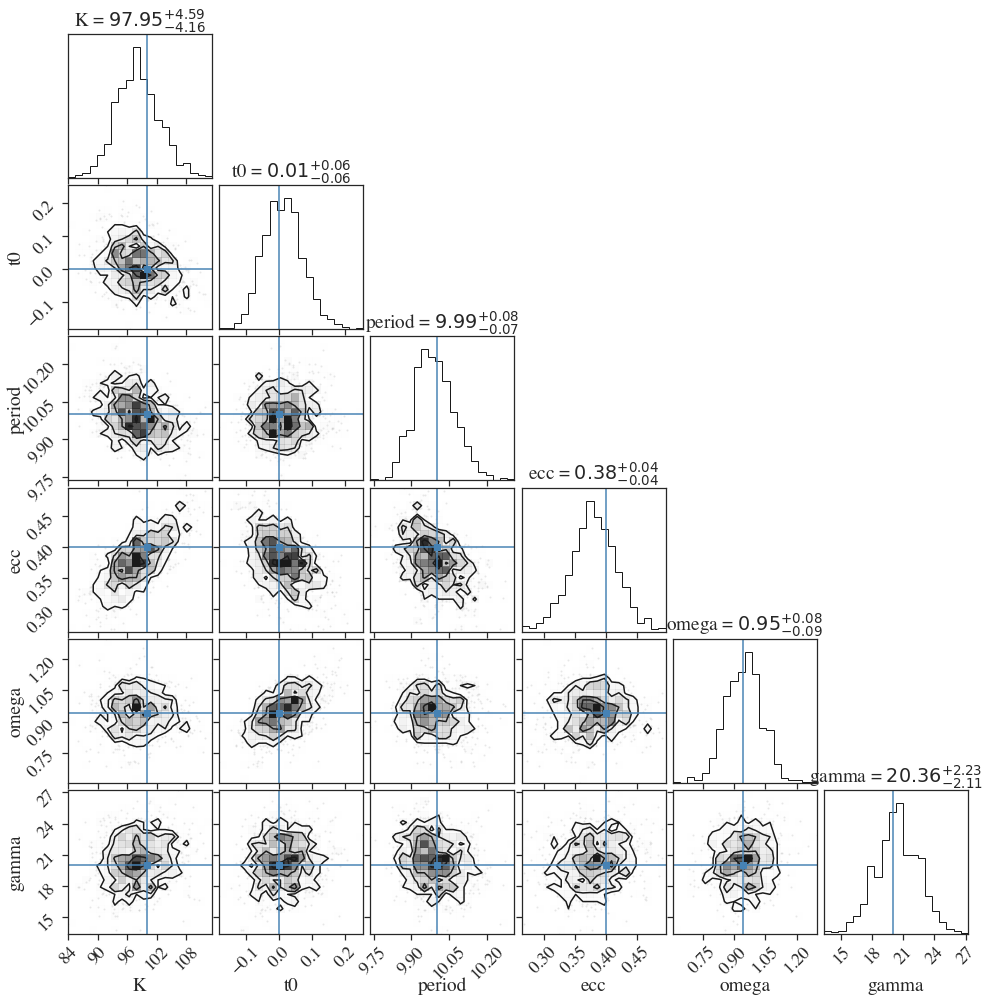

In [22]:
samples2 = mcmc2.get_samples()
fig = corner.corner(np.array([np.array(samples2[key]) for key in params]).T,
                   show_titles=True, truths=[K, t0, period, ecc, omega, gamma], labels=params)

## 2.5. what if the emax matters?

In [23]:
rng_key = random.PRNGKey(0)
mcmc2.run(rng_key, t, y_obs, error_obs, 0, 10., emax=0.45)

sample: 100%|█████████████████████████████████████| 2000/2000 [00:06<00:00, 307.66it/s, 7 steps of size 1.53e-01. acc. prob=0.97]


In [24]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     ecosw      0.36      0.04      0.36      0.29      0.43    311.13      1.00
     esinw      0.50      0.04      0.50      0.43      0.56    321.62      1.01
     gamma     20.34      2.09     20.32     17.52     24.21    477.97      1.00
      logK      1.99      0.02      1.99      1.96      2.02    400.46      1.00
    period      9.99      0.08      9.98      9.86     10.12    448.95      1.00
        t0      0.02      0.06      0.01     -0.08      0.11    408.55      1.00

Number of divergences: 160


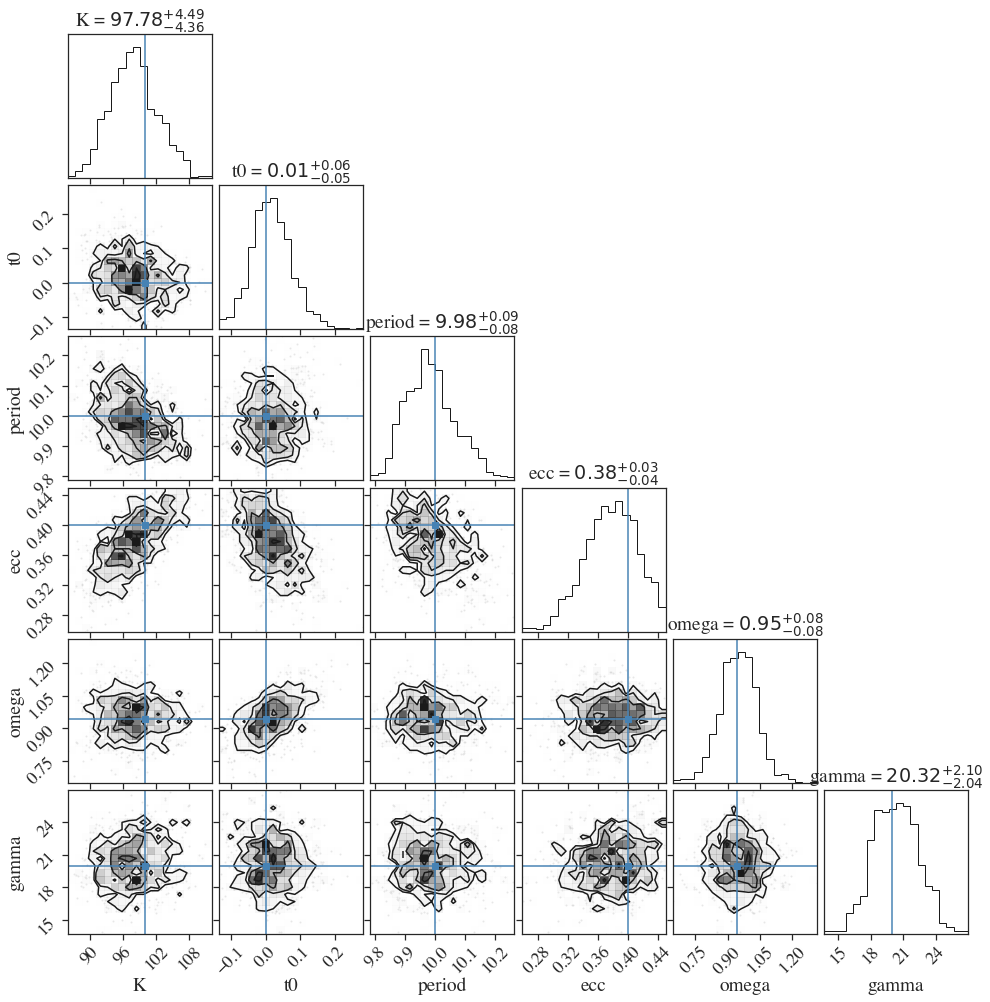

In [25]:
samples2 = mcmc2.get_samples()
fig = corner.corner(np.array([np.array(samples2[key]) for key in params]).T,
                   show_titles=True, truths=[K, t0, period, ecc, omega, gamma], labels=params)

## 3. sampling using ecosw and esinw with modified bounds

In [26]:
def smbound(x, low, upp, s=1000, depth=30):
    return -depth*(1./(jnp.exp(s*(x-low))+1)+1./(jnp.exp(-s*(x-upp))+1))

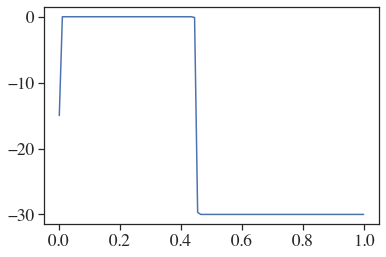

In [27]:
es = np.linspace(0, 1, 100)
plt.plot(es, smbound(es, 0, 0.45))

In [28]:
def model3(t, y, yerr, t0_guess, period_guess, emax=0.95):
    logK = numpyro.sample("logK", dist.Uniform(-5, 5))
    K = numpyro.deterministic("K", 10**logK)

    # using ecosw and esinw instead
    ecosw = numpyro.sample("ecosw", dist.Uniform(-1, 1))
    esinw = numpyro.sample("esinw", dist.Uniform(-1, 1))
    #ecc = numpyro.deterministic("ecc", jnp.sqrt(ecosw**2+esinw**2))
    ecc = numpyro.deterministic("ecc", ecosw**2+esinw**2)
    omega = numpyro.deterministic("omega", jnp.arctan2(esinw, ecosw))
    numpyro.factor("elimit", smbound(ecc, 0., emax))
    
    period = numpyro.sample("period", dist.Uniform(period_guess*0.95, period_guess*1.05))
    t0 = numpyro.sample("t0", dist.Uniform(t0_guess-0.1*period_guess, t0_guess+0.1*period_guess))
    tau = numpyro.deterministic("tau", t0_to_tau(t0, period, ecc, omega))
    
    rv_no_offset = numpyro.deterministic("rv_no_offset", K * getrv(t, period, ecc, omega, tau))
    gamma = numpyro.sample("gamma", dist.Uniform(low=-30, high=30))
    rvmodel = numpyro.deterministic("rvmodel", rv_no_offset + gamma)
    
    numpyro.sample("obs", dist.Normal(rvmodel, yerr), obs=y)

In [29]:
kernel3 = numpyro.infer.NUTS(model3, target_accept_prob=0.95)
mcmc3 = numpyro.infer.MCMC(kernel3, num_warmup=n_wm, num_samples=n_sample)

In [30]:
rng_key = random.PRNGKey(0)
mcmc3.run(rng_key, t, y_obs, error_obs, 0, 10., emax=0.45)

sample: 100%|█████████████████████████████████████| 2000/2000 [00:06<00:00, 290.55it/s, 7 steps of size 1.42e-01. acc. prob=0.94]


In [31]:
mcmc3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     ecosw      0.35      0.05      0.36      0.28      0.43    362.17      1.01
     esinw      0.50      0.04      0.50      0.44      0.56    414.58      1.01
     gamma     20.41      2.10     20.35     17.15     24.03    483.12      1.00
      logK      1.99      0.02      1.99      1.96      2.02    506.74      1.00
    period      9.99      0.08      9.98      9.86     10.13    481.42      1.00
        t0      0.02      0.06      0.01     -0.08      0.12    455.59      1.00

Number of divergences: 10


In [32]:
samples3 = mcmc3.get_samples()

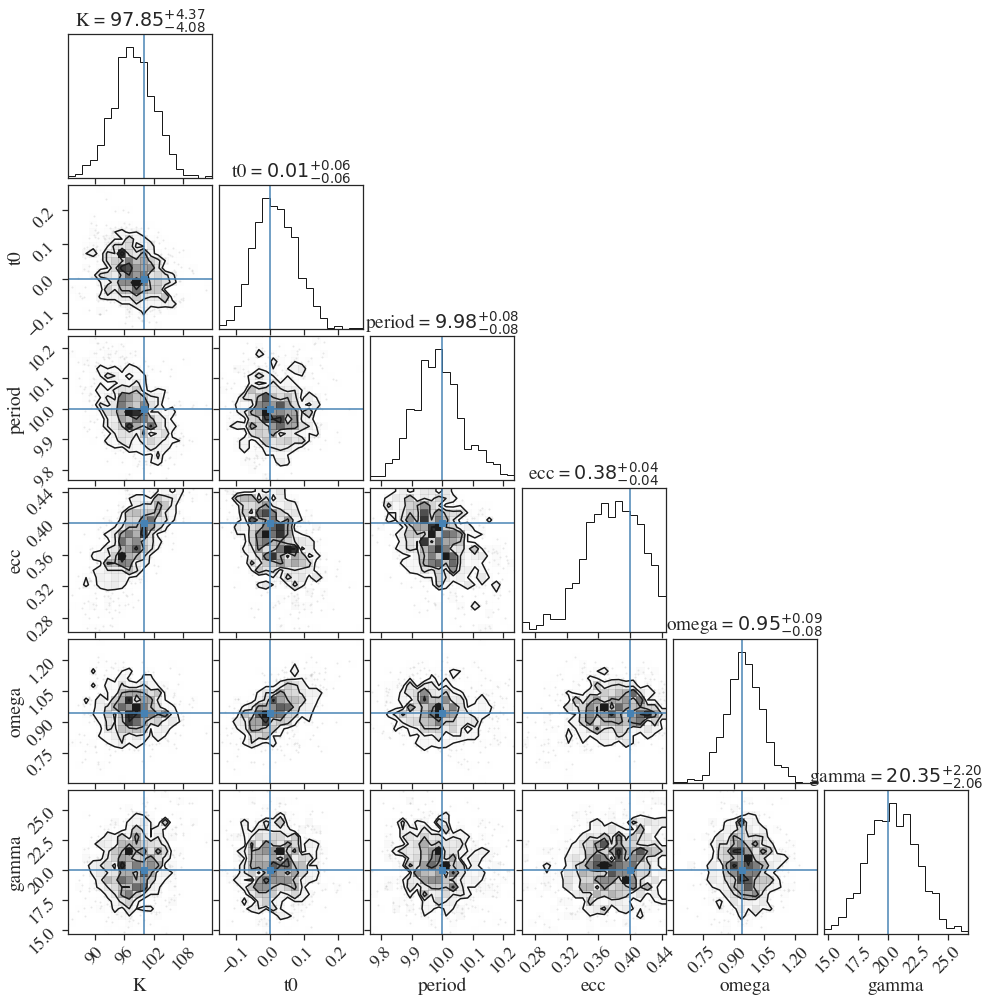

In [33]:
fig = corner.corner(np.array([np.array(samples3[key]) for key in params]).T,
                   show_titles=True, truths=[K, t0, period, ecc, omega, gamma], labels=params)